In [48]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

In [49]:
df = pd.read_csv("data/processed/processed_data_30124.csv", index_col=0)

### 1. Split train and test

In [50]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state=123)

### 2. KMeans without text data

In [51]:
# try kmeans without text data
X_train = train_df.drop("processed_text", axis=1)

In [52]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit_transform(X_train)

array([[3.69649244e+01, 3.16218521e+05, 1.47357977e+05],
       [3.84078959e+01, 3.16218521e+05, 1.47357978e+05],
       [3.70506401e+01, 3.16219520e+05, 1.47358968e+05],
       ...,
       [3.96613186e+01, 3.16219520e+05, 1.47358969e+05],
       [3.86531063e+01, 3.16219520e+05, 1.47358969e+05],
       [3.75355958e+01, 3.16218521e+05, 1.47357977e+05]])

In [53]:
cluster_dict = defaultdict(list)

for i, tweet in enumerate(train_df['processed_text']):
    cluster_dict[kmeans.labels_[i]].append(tweet)

In [54]:
print(len(cluster_dict[0]), len(cluster_dict[1]), len(cluster_dict[2]))

24095 2 2


### 3. KMeans with text data

In [55]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler())

In [56]:
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
text_feature = "processed_text"

In [57]:
## BOW + vectorize text data

bow_preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (CountVectorizer(ngram_range=(1, 2), stop_words="english"), text_feature) # unigram and bigram
)
bow_preprocessor;

In [58]:
train_enc = bow_preprocessor.fit_transform(train_df)
vocab = bow_preprocessor.named_transformers_['countvectorizer'].vocabulary_
print(train_enc.shape)

(24099, 189158)


In [40]:
### SVD
svd = TruncatedSVD(n_components=500)
X_500 = svd.fit_transform(train_enc)
print(X_500.shape)

(24099, 500)


In [15]:
# SCALE BOW REPRESENTATION
# scaler = StandardScaler(with_mean=False)
# train_enc_scaled = scaler.fit_transform(train_enc)
# print(train_enc_scaled.shape)

(24099, 189158)


In [59]:
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit_transform(X_500)

array([[ 4.61806219,  2.70627807, 94.21000499],
       [ 5.01159853,  3.21616947, 94.21817541],
       [ 4.99147135,  3.77019576, 94.24636725],
       ...,
       [ 4.3117821 ,  4.4531489 , 94.19071023],
       [ 5.35546183,  3.05082368, 94.26162605],
       [ 5.51652385,  5.88779724, 94.21656619]])

In [60]:
cluster_dict = defaultdict(list)

for i, tweet in enumerate(train_df['processed_text']):
    cluster_dict[kmeans.labels_[i]].append(tweet)

In [61]:
print(len(cluster_dict[0]), len(cluster_dict[1]), len(cluster_dict[2]))

9768 14327 4


In [63]:
print("GROUP_0: ", cluster_dict[0][20])
print("GROUP_1: ", cluster_dict[1][0])
print("GROUP_2: ", cluster_dict[2][2])

GROUP_0:  compare covid vaccine what ’ s the difference between the pfizer and the moderna dose here ’ s what we know about them so far via
GROUP_1:  pfizer vaccine in dubai how to book an appointment
GROUP_2:  with covid case surge worse than ever get vaccinate be one of the most important thing we can do but until the vaccine be widely available socially distance and wear mask will actually save even more life and alleviate the pressure on healthcare worker


### 4. SMOTE

In [64]:
from imblearn.over_sampling import SMOTE

In [70]:
# we don't have target!
sm = SMOTE(random_state=123)
sm_train = sm.fit_resample(train_enc)

TypeError: fit_resample() missing 1 required positional argument: 'y'

### 5. Gensim W2V

In [100]:
from gensim.models import Word2Vec

text_df = train_df[['processed_text']]
corpus = [sent.split() for sent in text_df['processed_text']]

In [101]:
corpus[0]

['pfizer', 'vaccine', 'in', 'dubai', 'how', 'to', 'book', 'an', 'appointment']

In [125]:
w2v_model = Word2Vec(sentences=corpus, iter=30, workers=1, seed=123, size=300, window=10, sg=0, negative=10)
w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=30)

(12771810, 18572910)

In [130]:
word_vectors = w2v_model.wv

In [132]:
word_vectors.vectors.shape

(5401, 300)

In [133]:
kmeans = KMeans(n_clusters=3, random_state=123).fit(X=word_vectors.vectors)

In [134]:
len(kmeans.labels_)

5401

In [137]:
cluster_dict_vocabs = defaultdict(list)

for i, vocab in enumerate(word_vectors.vocab):
    cluster_dict_vocabs[kmeans.labels_[i]].append(vocab)

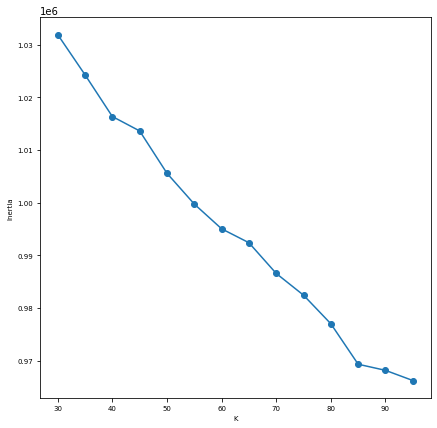

In [147]:
import matplotlib.pyplot as plt

w=7
h=7

def plot_elbow(kmeanses, min_range, max_range, step):
    plt.figure(figsize = (w,h))
#     plt.axvline(x=80, linestyle='-.', c="black")
    plt.plot(range(min_range,max_range,step),[k.inertia_ for k in kmeanses], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
kmeanses = []
min_range=30
max_range=100
step=5

for k in range(min_range, max_range, step):
    kmeanses.append(KMeans(n_clusters = k, random_state=123).fit(word_vectors.vectors))
plot_elbow(kmeanses, min_range, max_range, step)

In [148]:
kmeans = KMeans(n_clusters=85, random_state=123).fit(X=word_vectors.vectors)

In [149]:
cluster_dict_vocabs = defaultdict(list)

for i, vocab in enumerate(word_vectors.vocab):
    cluster_dict_vocabs[kmeans.labels_[i]].append(vocab)

In [152]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords_set = stopwords.words("English")

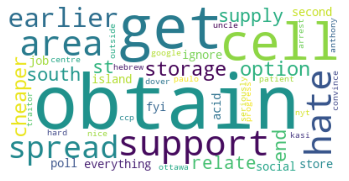

In [158]:
wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(" ".join(cluster_dict_vocabs[30]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

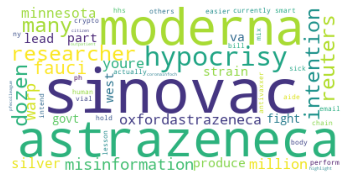

In [164]:
wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(" ".join(cluster_dict_vocabs[3]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

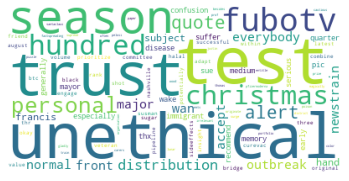

In [165]:
wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(" ".join(cluster_dict_vocabs[11]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()